### AB Model from spec

Package installation

In [8]:
# !pip3 install seaborn
# !pip3 install python-statemachine
# !pip3 install mesa
# !pip3 install transitions
# !pip3 install scipy
# !pip3 install cufflinks
# !pip3 install graphviz pygraphviz
# !pip3 install graphviz
# !pip3 install transitions[diagrams]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 4.3 MB/s eta 0:00:00


Package importation

In [6]:
# imports
import seaborn as sns
from random import choice
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt, patches
import scipy.stats as ss
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot
from statemachine import StateMachine, State
from transitions import Machine
import random
from transitions.extensions import GraphMachine
# os.environ["PATH"] += os.pathsep + '/Users/akintomiwa/homebrew/bin'


In [7]:
class EVSM(Machine):
    """A state machine for managing status of EV agent in AB model.
Can be deployed as EvState object.

States:
    Idle, Travel, In_queue, Charge, Travel_low, End
Transitions:
    start_travel: Idle -> Travel
    get_low: Travel -> Travel_low
    join_charge_queue: Travel_low -> In Queue
    start_charge: In Queue -> Charge
    end_charge: Charge -> Travel
    continue_travel: Travel -> Travel
    continue_charge: Charge -> Charge
    end_travel: Travel -> Idle
    """

states = ['Idle', 'Travel', 'In_queue', 'Charge', 'Travel_low']
transitions = [
    {'trigger': 'start_travel', 'source': 'Idle', 'dest': 'Travel'},
    {'trigger': 'get_low', 'source': 'Travel', 'dest': 'Travel_low'},
    {'trigger': 'join_charge_queue', 'source': 'Travel_low', 'dest': 'In_queue'},
    {'trigger': 'start_charge', 'source': 'In_queue', 'dest': 'Charge'},
    {'trigger': 'continue_charge', 'source': 'Charge', 'dest': 'Charge'},
    {'trigger': 'end_charge', 'source': 'Charge', 'dest': 'Travel'},
    {'trigger': 'continue_travel', 'source': 'Travel', 'dest': 'Travel'},
    {'trigger': 'end_travel', 'source': 'Travel', 'dest': 'Idle'},
]


State diagram

In [9]:
from transitions.extensions import GraphMachine
from functools import partial

class Model:
    def clear_sstate(self, deep=False, force=False):
        print("Clearing State ... ")
        return True

model = Model()
machine = GraphMachine(model=model, states=['Idle', 'Travel', 'In_queue', 'Charge', 'Travel_low'],
                        transitions= [
                        {'trigger': 'start_travel', 'source': 'Idle', 'dest': 'Travel'},
                        {'trigger': 'get_low', 'source': 'Travel', 'dest': 'Travel_low'},
                        {'trigger': 'join_charge_queue', 'source': 'Travel_low', 'dest': 'In_queue'},
                        {'trigger': 'start_charge', 'source': 'In_queue', 'dest': 'Charge'},
                        {'trigger': 'continue_charge', 'source': 'Charge', 'dest': 'Charge'},
                        {'trigger': 'end_charge', 'source': 'Charge', 'dest': 'Travel'},
                        {'trigger': 'continue_travel', 'source': 'Travel', 'dest': 'Travel'},
                        {'trigger': 'end_travel', 'source': 'Travel', 'dest': 'Idle'},
                        ], 
                        initial = 'Idle', show_conditions=True)

model.get_graph().draw('my_state_diagram.png', prog = 'dot')

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [105]:
a = EVSM(initial='Idle', states=states, transitions=transitions)

In [117]:
# if a.state == 'Idle':
#     a.start_travel()
#     print(a.state)
# print(a.state)
# ///
# a.state
# a.start_travel()
# a.state
# a.get_low()
# a.state
# a.join_charge_queue()
# a.state
# a.start_charge()
# a.state
# a.end_charge()
# a.state
# a.continue_travel()
# a.state
# a.end_travel()
# a.state


'Idle'

In [10]:
# Config
ticks = 240 # 240 ticks = 10 days
no_cars = 10
no_cpoints = 2

In [11]:
# def get_evs_charged(model):
#     evs_charged = [ev._was_charged for ev in model.evs]
#     no_evs_charged = np.sum(evs_charged)
#     return no_evs_charged

# def get_evs_charge_level(agent):
#     evs_levels = [ev.soc for ev in model.evs]
#     # no_evs_active = np.sum(evs_active)
#     return evs_levels

# def get_evs_charged(model):
#     evs_charged = [ev._was_charged for ev in model.evs]
#     no_evs_charged = np.sum(evs_charged)
#     return no_evs_charged

def get_evs_charge_level(model):
    evs_levels = [ev.soc for ev in model.evs]
    # no_evs_active = np.sum(evs_active)
    return evs_levels

# rewrite

def get_evs_active(model):
    evs_active = [ev._is_active for ev in model.evs]
    no_evs_active = np.sum(evs_active)
    return no_evs_active

def get_evs_charging(model):
    evs_charging = [ev._is_charging is True for ev in model.evs]
    no_evs_charging = np.sum(evs_charging)
    return no_evs_charging

# State machine based functions
def get_evs_travel(model):
    evs_travel = [ev.machine.state == 'Travel' for ev in model.evs]
    no_evs_travel = np.sum(evs_travel)
    return no_evs_travel

def get_evs_not_idle(model):
    evs_not_idle = [ev.machine.state != 'Idle' for ev in model.evs]
    no_evs_not_idle = np.sum(evs_not_idle)
    return no_evs_not_idle


In [275]:
a = np.int(ss.uniform(0, 24).rvs(1)) + 1
# np.int(ss.uniform(0, 24).rvs(1) * ticks) + 1
print(a)

17


In [5]:
class ChargingPoint(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.queue = []
        self._is_charging = True
        self.active_ev = None
        self.entry_time = np.int(ss.uniform(0, 24).rvs(1)) + 1
    def dequeue(self):
        try:
            self.active_ev = self.queue.pop(0)
            self.active_ev._queue_entry = self.model._current_tick
            self.active_ev._queue_exit = self.model._current_tick
        except:
            pass

    def step(self):
        if self.active is None:
            self.dequeue()



In [15]:
class EV(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self._max_battery = 100
        self._soc_usage_thresh = 10
        self.soc_charging_thresh = 70
        # self.soc_charging_thresh = (self._max_battery)/2 # soc level at which EV driver is comfortable with ending charging at station.
        self._charge_rate = 10
        self._in_queue = False
        self._in_garage = False
        self._is_charging = False
        self._was_charged = False
        self._is_travelling = False
        self._journey_complete = False
        # self.state = EvStateMachine(start_value = 'idle')
        self.machine= EVSM(initial='Idle', states=states, transitions=transitions)
        # self._loc_init = 
        # self._soc_init = 50 #initially 50 (+/- 10?). if over multiple days, use learnt value from prev day. If overnight charge, set to 100. write methods to handle cases later.
        # self.queue_time = self.chargerate * self. 
        self.soc = ss.poisson(45).rvs()
        self._pos_init = None #Urgent Fix soon
        self._is_active = True
        self.odometer = 0
        self._distance_goal = None
        self.journey_type = None
        # External 
        self.journey_choice = choice([True, False])
        # For interaction with other agent classes - CPs, garages, etc.:
        self.start_time = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
        self.entry_time = np.int(ss.beta(3, 3).rvs() * ticks) + 1
        # self._cp_entry = None
        # self._cp_exit = None
        # self._charge_start = None
        # Time of arrival at queue
        

        if self.journey_choice == True:
            self._distance_goal = 50
            self.journey_type = "Urban"
        else:
             self._distance_goal = 100
             self.journey_type = "InterUrban"
        print("EV No " + str(self.unique_id + 1) + " initialized. Journey type: " + str(self.journey_type) +
        ". Vehicle State: " + str(self.machine.state) )


    def travel(self):
        self.odometer += 10
        self.soc -= 5
        print("Vehicle " + str(self.unique_id + 1 ) + " is travelling")

    def select_cp(self):
        self._in_queue = True
        # queue at shortest cp
        self._chosen_cp_idx = np.argmin([
            len(cpoint.queue) for cpoint in self.model.cpoints])
        self._chosen_cp = self.model.cpoint[self._chosen_cpoint_idx]
        self._in_queue = True
    
    def charge_simple(self):
        # self._is_charging = True
        # alt - with sm
        # self.state.start_charge()
        self.soc += self._charge_rate
        # self._is_charging = False
        self._was_charged = True
        print("Vehicle " + str(self.unique_id + 1 ) + " charging status: " + str(self._was_charged)+ ". CLevel: " + str(self.soc))
                
    # def charge_main(self):
    #     self._is_charging = True
    #     self._cp_exit = self.model._current_tick
    #     self._chosen_cp.active_car = None
    #     self.soc += self._charge_rate
    #     # self._is_charging = False
    #     self._was_charged = True
    #     print("Vehicle " + str(self.unique_id + 1 ) + " charging status: " + str(self._was_charged)+ ". CLevel: " + str(self.soc))
    # def charge_overnight(self):
    #     if self._in_garage == True & self.soc < self._max_battery:
    #         # self.soc = self._max_battery
    #         self.soc += self._charge_rate
    #     self._is_charging = True
    #     self._was_charged = True
            
      # ////
    def step(self):
        # Block A - Transitions state machine:
        # Transition Case 1: Start travelling. idle -> travel
        if self.machine.state == 'Idle' and self.odometer < self._distance_goal:
            self.machine.start_travel()
            print("Current EV state: " + str(self.machine.state))
        if self.machine.state == 'Travel':
            self.machine.continue_travel()
            self.travel()
            print("Current EV state: " + str(self.machine.state))
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
        # Transition Case 2: Still travelling, battery low. Travel -> travel_low
        if self.soc <= self._soc_usage_thresh:
            self.machine.get_low()
            print("Current EV state: " + str(self.machine.state))
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
        # Transition Case 3: Stopped travelling, Join queue, select cp. Travel_low -> in_queue
        if self.machine.state == 'Travel_low' and self.odometer < self._distance_goal:
            self.machine.join_charge_queue()
            print("Current EV state: " + str(self.machine.state))
            print("Vehicle " + str(self.unique_id + 1 ) + " is in charging queue " + str(self._chosen_cpoint.unique_id) + " . CLevel: " + str(self.soc))
        # Transition Case 4: Start charging. In_queue -> charge
        if self.machine.state == 'In_queue':
            if self.soc < self.soc_charging_thresh:
                self.machine.start_charge()
                self.charge_simple()
            else:
                # self.soc >= self.soc_charging_thresh:
                self.machine.end_charge()
        # Transition Case 5: Continue charging. Charge -> charge
        if self.machine.state == 'Charge':
            if self.soc >= self.soc_charging_thresh:
                self.machine.end_charge()
            else:
                self.machine.continue_charge()
                self.charge_simple()
        # Transition Case 6: Journey Complete. travel -> idle
        if self.machine.state == 'Travel' and self.odometer == self._distance_goal:
            self.machine.end_travel()
            print("Current EV state: " + str(self.machine.state))
            print("Vehicle " + str(self.unique_id + 1) + " has completed its journey and is now " + str(self.machine.state))
        # Transition Case 7: Jouney Complete. travel_low -> idle. JIT


        
class EVModel(Model):
    """Simulation Model with EV agents."""

    def __init__(self, no_evs, ticks):
        # super().__init__()
        # init with input args
        self.ticks = ticks
        self._current_tick = 1
        self.no_evs = no_evs
        # other key model attr 
        self.schedule = RandomActivation(self)
        # Populate model with agents
        self.evs = []
        for i in range(self.no_evs):
            ev = EV(i,self)
            self.schedule.add(ev)
            self.evs.append(ev)
        self.datacollector = DataCollector(
            model_reporters={'EVs Charged': get_evs_charged,
                             'EVs Activated': get_evs_active,
                             'EVs Travelling': get_evs_travel,
                             'EVs Charge Level': get_evs_charge_level,
                             'EVs Currently charging': get_evs_charging,
                             'EVs Not Idle': get_evs_not_idle,
                             }
            )
    
    def step(self):
        """Advance model one step in time"""
        print("Current tick: "+ str(self._current_tick) + ".")
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1

In [13]:
ticks = 24 # 3600 ticks = 3600 seconds = 1 hour
no_evs = 20
no_cps = 2

In [17]:
# no_cpoints = 2
model = EVModel(ticks=ticks, no_evs=no_evs)
for i in range(ticks):
    # print(len(model.evs))
    model.step()
model.datacollector.get_model_vars_dataframe()


EV No 1 initialized. Journey type: Urban. Vehicle State: Idle
EV No 2 initialized. Journey type: Urban. Vehicle State: Idle
EV No 3 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 4 initialized. Journey type: Urban. Vehicle State: Idle
EV No 5 initialized. Journey type: Urban. Vehicle State: Idle
EV No 6 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 7 initialized. Journey type: Urban. Vehicle State: Idle
EV No 8 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 9 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 10 initialized. Journey type: Urban. Vehicle State: Idle
EV No 11 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 12 initialized. Journey type: Urban. Vehicle State: Idle
EV No 13 initialized. Journey type: Urban. Vehicle State: Idle
EV No 14 initialized. Journey type: InterUrban. Vehicle State: Idle
EV No 15 initialized. Journey type: Urban. Vehicle State: Idle
EV No 16 initialized. Journey type

AttributeError: 'EVModel' object has no attribute 'random'

In [53]:
# # model.datacollector.get_agent_vars_dataframe()
# model.datacollector.get_model_vars_dataframe()


In [98]:
run_stats = model.datacollector.get_model_vars_dataframe()
print(run_stats)


    EVs Charged  EVs Activated  EVs Travelling  \
0             0             50               0   
1             0             50              50   
2             0             50              50   
3             0             50              50   
4             1             50              49   
5             1             50              27   
6             8             50              20   
7            14             50              14   
8            25             50               3   
9            28             50               1   
10           28             50               0   
11           28             50               3   
12           28             50               9   
13           28             50              17   
14           28             50              25   
15           28             50              17   
16           28             50               0   
17           28             50               0   
18           28             50               0   


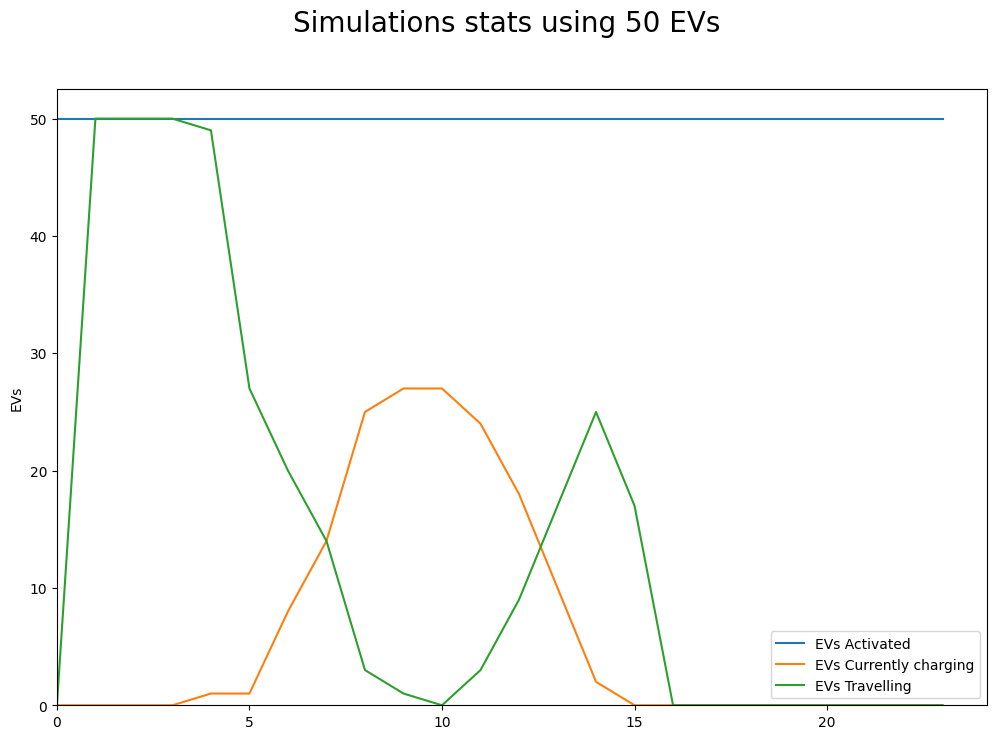

In [99]:
fig, (ax1) = plt.subplots(1, 1)
fig.figure.set_figwidth(12)
fig.figure.set_figheight(8)
fig.suptitle(f'Simulations stats using {no_evs} EVs', fontsize=20)
ax1.plot(run_stats[['EVs Activated',
                'EVs Currently charging',
                'EVs Travelling'
               ]])
ax1.legend(['EVs Activated',
            'EVs Currently charging',
            'EVs Travelling',
            ])
ax1.set_ylabel('EVs')
ax1.set_xlim(0)
ax1.set_ylim(0)
fig.show()

In [85]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# fig.figure.set_figwidth(12)
# fig.figure.set_figheight(16)
# fig.suptitle(f'Simulations stats using {no_evs} EVs', fontsize=20)
# ax1.plot(run_stats[['EVs Activated',
#                 'EVs Charged',
#                 'EVs Travelling'
#                ]])
# ax1.legend(['EVs Activated',
#             'EVs Charged',
#             'EVs Travelling',
#             ])
# ax1.set_ylabel('EVs')
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax2.plot(run_stats['Average Queue Size'], color='red')
# ax2.legend(['Average Queue Size'])
# ax2.set_ylabel('Customers')
# ax2.set_xlim(0)
# ax2.set_ylim(0)
# ax3.plot(run_stats['EVs Travelling'], color='grey')
# ax3.legend(['EVs Travelling (across full day    )'])
# ax3.set_ylabel('Hours')
# ax3.set_xlim(0)
# ax3.set_ylim(0)
# # ax4.plot(run_stats[['Gross Margin',
# #                 'Operating Costs',
# #                 'Total Profit'
# #                ]])
# # ax4.legend(['Gross Margin',
# #             'Operating Costs',
# #             'Total Profit'
# #             ])
# # ax4.set_ylabel('Dollars')
# # ax4.set_xlim(0)
# fig.show()

In [86]:
# from mesa.visualization.modules import CanvasGrid
# from mesa.visualization.ModularVisualization import ModularServer

# def agent_portrayal(agent):
#     portrayal = {"Shape": "circle",
#                  "Filled": "true",
#                  "Layer": 0,
#                  "Color": "red",
#                  "r": 0.5}
#     return portrayal

# grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
# server = ModularServer(Model,
#                        [grid],
#                        "My Model",
#                        {'n_agents': 10})
# server.launch()

### Scrapbook

In [ ]:
# probability distribution exploration Dec 22

# Method 1
# # distr = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
# # print(distr[34])
# x = np.arange(1, 25)
# xU, xL = x + 0.5, x - 0.5 
# prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
# prob = prob / prob.sum() # normalize the probabilities so their sum is 1
# nums = np.random.choice(x, size = 10000, p = prob)
# plt.hist(nums, bins = len(x))

# Method 2
# import numpy as np
# from scipy.stats import truncnorm
# import matplotlib.pyplot as plt

# scale = 3.
# range = 10
# size = 100000

# X = truncnorm(a=-range/scale, b=+range/scale, scale=scale).rvs(size=size)
# X = X.round().astype(int)
# bins = 2 * range + 1
# plt.hist(X, bins)

In [ ]:
# generate random numbers from N(0,1) # normal distribution for start time - 5am to 8pm
# type -> array of 1000 elements
# data_normal = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
# print(data_normal[50])

In [ ]:
# initial approach to EV agent step method
    # approach works, little quirks. control flow faulty. does not allow for stepwise charging
    
    # if self.model._current_tick >= self.start_time:
    # while (self.odometer < self._distance_goal) & self.soc > self._soc_thresh: # didnt work. 
    # self.select_journey_type()
    # if self.odometer < self._distance_goal:
    #     self.travel()
    #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle travelled: " + str(self.odometer) + " distance units")
    #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
    #     if self.odometer == self._distance_goal:
    #         self._journey_complete == True
    #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
    #         self._is_active == False
    #         self._is_travelling == False
    #         self._in_garage == True

    # if (self.soc < self._soc_thresh) & (self._is_travelling == True):
    #     self._is_travelling == False
    #     print("Vehicle "+ str(self.unique_id + 1)  + " has hit SOC threshold. Heading to charging station")
    #     self._is_charging == True
    #     self.charge() #charge
    #     self.travel()
            

In [ ]:
# from travel

        # print("Vehicle id: " + str(self.unique_id) + ". This vehicle travelled: " + str(self.odometer) + " distance units")
        # print("Vehicle id: " + str(self.unique_id) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
            
        # if self.soc < self._soc_thresh:
        #     self._is_travelling == False
        #     self.charge() #charge



In [ ]:
# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size

# def get_avg_waiting_time(model):
#     cars_wait = [np.nan if car._cp_exit is None else
#                       car._cp_exit - car._cp_entry for car in model.cars]
#     avg_customer_wait = np.nanmean(cars_wait)
#     return avg_customer_wait

# def get_customers_served(model):
#     customers_served = [not(customer._service_exit is None) for customer in model.customers]     
#     no_customers_served = np.sum(customers_served)
#     return no_customers_served
# def get_customers_balked(model):
#     customers_arrived = [
#         customer._arrived for customer in model.customers]
#     # Customers who never joined a queue
#     customers_no_q = np.array([
#         customer._q_entry is None for customer in model.customers])
#     no_customers_balked = np.sum(customers_arrived * customers_no_q)
#     return no_customers_balked
# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size
# def get_avg_waiting_time(model):
#     customers_wait = [np.nan if customer._q_exit is None else
#                       customer._q_exit - customer._q_entry for customer in model.customers]
#     avg_customer_wait = np.nanmean(customers_wait)
#     return avg_customer_wait
# def get_gross_margin(model):
#     return gross_margin_per_customer * get_customers_served(model)
# def get_operating_costs(model):
#     return cost_per_counter * no_counters
# def get_total_profit(model):
#     return get_gross_margin(model) - get_operating_costs(model)

In [ ]:
# # ext

# import random

# from mesa import Agent, Model
# from mesa.time import RandomActivation

# class EV(Agent):
#     def __init__(self, unique_id, model):
#         super().__init__(unique_id, model)
#         self.battery = 100 # start with a fully charged battery
#         self.distance_to_travel = random.randint(50, 150) # set random distance to travel

#     def step(self):
#         # if battery is low, go to charging station
#         if self.battery < 20:
#             self.go_to_charging_station()
#         # if there is still distance to travel and the battery is not low, drive
#         elif self.distance_to_travel > 0:
#             self.drive()
#         # if there is no distance left to travel, do nothing
#         else:
#             return

#     def drive(self):
#         self.distance_to_travel -= 1
#         self.battery -= 1

#     def go_to_charging_station(self):
#         self.battery = 100 # fully charge the battery

# class EVModel(Model):
#     def __init__(self, num_evs):
#         self.num_evs = num_evs
#         self.schedule = RandomActivation(self)
#         # create agents
#         for i in range(self.num_evs):
#             ev = EV(i, self)
#             self.schedule.add(ev)


    # def select_journey_type(self):
    #     self._is_active == True
    #     if self.journey_choice == True:
    #         self._distance_goal = 50
    #         self.journey_type = "Urban"
    #     else:
    #          self._distance_goal = 100
    #          self.journey_type = "InterUrban"
    #     if self._is_travelling == True & self._is_active == True:
    #         print("This car's id is: " + str(self.unique_id) + " and it's going on an " + str(self.journey_type) + " journey" + " with a distance goal of " 
    #         + str(self._distance_goal))
    #     # print("Journey type selected: " + str(self._distance_goal))



In [ ]:
    # cpgen
    # def dequeue(self):
    #     if len(self.queue) > 0:
    #         self.active_ev = self.queue.pop(0)
    #         self.active_ev._is_charging = True
    #         self.active_ev._is_active = True
    #         self._is_charging = True
    #         self.active_ev._charge_start_time = self.model.schedule.time
    #         self.active_ev._charge_end_time = self.active_ev._charge_start_time + self.active_ev._charge_duration
    #     else:
    #         self.active_ev = None
    #         self._is_charging = False

In [ ]:
# class EvStateMachine(StateMachine):
#     """A state machine for managing status of EV agent in AB model.
#     Can be deployed as EvState object.

#     States:
#         Idle
#         Travelling
#         In Queue
#         Charging
#         Travelling Low
#     Transitions:
#         start_travel: Idle -> Travelling
#         join_charge_queue: Travelling -> In Queue
#         start_charge: In Queue -> Charging
#         end_charge: Charging -> Travelling
#         continue_travel: Travelling -> Travelling
#         end_travel: Travelling -> Idle

#         """
#     idle = State('Idle', initial=True)
#     travelling = State('Travelling')
#     in_queue = State('In Queue')
#     charging = State('Charging')
#     travelling_low = State('Travelling Low')

#     start_travel = idle.to(travelling)
#     join_charge_queue = travelling.to(in_queue)
#     start_charge = in_queue.to(charging)
#     end_charge = charging.to(travelling)
#     continue_travel = travelling.to(travelling)
#     end_travel = travelling.to(idle)
#     travel_low = travelling.to(travelling_low)
    

#     def on_start_travel(self):
#         # travel()
#         print('SM: Travelling')
#     def on_continue_travel(self):
#         # travel()
#         print('SM: Travelling continues')
#     def on_join_charge_queue(self):
#         # join_charge_queue()
#         print('SM: Joining Charge Queue')
#     def on_start_charge(self):
#         # charge()
#         print('SM: Charging')
#     def on_end_charge(self):
#         # travel()
#         print('SM: Travelling')
#     def on_end_travel(self):
#         # idle()
#         print('SM: Idle')
#     def on_travel_low(self):
#         # travel_low()
#         print('SM: Travelling Low')
    
# # class EvState(object):
# #     def __init__(self, state):
# #         self.state = state

# # make EVstate obj which defaults to idle
# # obj = EvState(state='idle')
# # ev_state = EvStateMachine(obj)
# # # ev_state.is_idle


# #     # go = red.to(green)
# #     # def on_slowdown(self):
# #     #     print('Baba, calm dan')
# #     # def on_stop(self):
# #     #     print('hollit')
# #     # def on_go(self):
# #     #     print('Movement!')



In [ ]:
# # ////
    # def step(self):
    #     # Block A - old state machine [pySM] - not working:
    #     # Case: Start travelling. idle -> travel
    #     # if (self.odometer < self._distance_goal) & (self.soc > self._soc_usage_thresh) & (self.state.current_state == 'idle'):
    #     if self.state.current_state == EvStateMachine.idle:
    #         self.travel()
    #         # EvStateMachine.start_travel()
    #         self.state.current_state = EvStateMachine.travelling
    #         # print(self.state.current_state)
    #         print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
    #         print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
    #      # Transition Case: Jouney Complete. travel -> idle
    #     if self.odometer == self._distance_goal:
    #         self._journey_complete == True
    #         self.state.current_state = EvStateMachine.idle
    #         # self.state.current_state = EvStateMachine.end_travel()
    #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
    #         # self._is_active == False
    #         # self._is_travelling == False
    #     # Transition Case: Still travelling. Travel -> travel_low
    #     if self.soc < self._soc_usage_thresh:
    #         self.state.current_state = EvStateMachine.travelling_low
    #         # self.charge()
    #         print(self.state.current_state)
    #     # Transition Case: Stopped travelling, Select cp. Travel_low -> select cp
    #     if self.state.current_state == EvStateMachine.travelling_low:
    #         self.select_cp()
    #         self.state.current_state = EvStateMachine.in_queue
    #         print(self.state.current_state)
    #     # Transition Case: Start charging. In_queue -> charge
    #     if self.state.current_state == EvStateMachine.in_queue:
    #         self.charge()
    #         self.state.current_state = EvStateMachine.charging

    #     # Transition Case: Maintain charging. Charge -> charge
    #     if self.state.current_state == EvStateMachine.charging:
    #         self.charge()
    #         print(self.state.current_state)
            
    #     # Case: continue travelling. travel -> travel
    #     if self.state.current_state == EvStateMachine.travelling:
    #         self.travel()
    #         print(self.state.current_state)
    #         print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
    #         print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
    #         # a-a if distance_goal not reached,
    #         if self.odometer == self._distance_goal:
    #             self._journey_complete == True
    #             print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
    #             self._is_active == False
    #             self._is_travelling == False
    #             self._in_garage == True
    #     if (self.state.current_state == EvStateMachine.travelling_low):
    #         self.state.start_charge()
    #         print(self.state.current_state)

In [ ]:
# class Car(Agent):
#     """
#     Attr:

#     Flags:
    
    
#     """
#     def __init__(self, unique_id, model):
#         super().__init__(unique_id, model)
#         self._max_battery = 100
#         self._soc_thresh = 10
#         self._charge_rate = 20 #Vehicle soc rises at 20 per tick
#         self._in_queue = False
#         self._in_garage = False
#         self._is_charging = False
#         self._was_charged = False
#         self._is_travelling = False
#         self._journey_complete = False

#         # self._chargerate = None
#         # self._loc_init = 
#         # self._soc_init = 50 #initially 50 (+/- 10?). if over multiple days, use learnt value from prev day. If overnight charge, set to 100. write methods to handle cases later.
#         # self.queue_time = self.chargerate * self. 
#         self.soc = ss.poisson(45).rvs()
#         self._pos_init = None #Urgent Fix soon
#         self._is_active = False
#         self.odometer = 0
#         self._distance_goal = 0
#         self.journey_type = None
#         # External 
#         self.journey_choice = choice([True, False])
#         self.start_time = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
#         # self.select_journey_type()
#         # self._cp_entry = None
#         # self._cp_exit = None
#         # self._charge_start = None

#     def select_journey_type(self):
#         self._is_active == True
#         if self.journey_choice == True:
#             self._distance_goal = 50
#             self.journey_type = "Urban"
#         else:
#              self._distance_goal = 100
#              self.journey_type = "InterUrban"

#         # print("Journey type selected: " + str(self._distance_goal))


#     def travel(self):
#         self._is_travelling = True
#         self.odometer += 10
#         self.soc -= 5
#         # if self._is_travelling == True & self._is_active == True:
#         if self._is_travelling == True:
#             print("This car's id is: " + str(self.unique_id) + " and it's going on an " + str(self.journey_type) + " journey" + " with a distance goal of " 
#             + str(self._distance_goal))


#     # def select_cp(self):
#     #     # self._in_queue = True
#     #     # # queue at shortest cp
#     #     # self._chosen_cp_idx = np.argmin([
#     #     #     len(cpoint.queue) for cpoint in self.model.cpoints])
#     #     # self._chosen_cp = self.model.cpoint[self._chosen_cpoint_idx]
#     #     self._in_queue = True

    
#     def charge(self):
#         self._is_charging = True
#         # self._cp_exit = self.model._current_tick
#         # self._chosen_cp.active_car = None
#         # self.soc = self._max_battery
#         # while self.soc < self._max_battery:
#         #     self.soc += self._charge_rate
#         #     if self.soc == self._max_battery:
#         #         self._is_charging = False
#         if self.soc < self._max_battery:
#             self.soc += self._charge_rate
#             print("Vehicle " + str(self.unique_id) + " is charging")
#         if self.soc == self._max_battery:
#             print("Vehicle charged")
#         self._is_charging = False
#         self._was_charged = True
                

#     def charge_overnight(self):
#         if self._in_garage == True:
#             self.soc = self._max_battery
    
#     # def step(self):
#     #     if (self._in_queue == False) & (self.model._current_tick >= self.entry_time):
#     #         self.select_cp()
#     #     elif isinstance(self.self._cp_entry, int):
#     #         if self.model._current_tick - self._cp_entry == self.charge_time:
#     #             self.travel()
#     def step(self):
#         # while (self.odometer < self._distance_goal) & self.soc > self._soc_thresh: # didnt work. 
#         if (self.odometer < self._distance_goal):
#             self.travel()
#             print("Vehicle id: " + str(self.unique_id) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
#             print("Vehicle id: " + str(self.unique_id) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
#             if self.odometer == self._distance_goal:
#                 self._journey_complete == True
#                 print("Vehicle " + str(self.unique_id) + " has completed its journey")
#                 # self._is_active == False
#                 # self._is_travelling == False

#         if self.soc < self._soc_thresh & (self._journey_complete == False):
#             self._is_travelling == False
#             print("Vehicle has hit SOC threshold. Heading to charging station")
#             # self._is_charging == True
#             self.charge() #charge
#             self.travel()
            




# class MainModel(Model):
#     """Simulation Model with cars and charging points as two types of agents, interacting."""

#     def __init__(self, no_cars, ticks):
#         # super().__init__()
#         # init with input args
#         self.ticks = ticks
#         self._current_tick = 1
#         self.no_cars = no_cars
#         # other key model attr 
#         self.schedule = RandomActivation(self)
#         # Populate model with agents
#         self.cars = []
#         for i in range(self.no_cars):
#             car = Car(i,self)
#             self.schedule.add(car)

#         self.datacollector = DataCollector(
#             model_reporters={'Cars Charged': get_cars_charged,
#                              'Cars Activated': get_cars_active})
    
#     def step(self):
#         self.datacollector.collect(self)
#         self.schedule.step()
#         self._current_tick += 1



In [ ]:
# Old command flow for agent step function 


        # if self.machine.state == 'Charge':
        #     if self.soc >= self.soc_charging_thresh:
        #         self.machine.end_charge()


            # try:
            #     self.machine.continue_travel()
            #     self.travel()
            # except self.soc < self._soc_usage_thresh:
            #     self.machine.get_low()
            #     # self.charge()
            #     print("Current EV state: " + str(self.machine.state))
            #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
            #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")

            # Transition Case: Jouney Complete. travel -> idle
        # if self.odometer == self._distance_goal:
        #     self._journey_complete == True
        #     # self.state.current_state = EvStateMachine.idle
        #     self.state.end_travel()
        #     print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
        #     # self._is_active == False
        #     # self._is_travelling == False
        # # Transition Case: Still travelling. Travel -> travel_low
        # if self.soc < self._soc_usage_thresh:
        #     self.state.get_low()
        #     self.charge()
        #     print(self.state)
        # # Transition Case: Stopped travelling, Select cp. Travel_low -> select cp
        # if self.state == 'travel_low':
        #     self.select_cp()
        #     self.state.current_state = EvStateMachine.in_queue
        #     print(self.state.current_state)
        # Transition Case: Start charging. In_queue -> charge
        # if self.state.current_state == EvStateMachine.in_queue:
        #     self.charge()
        #     self.state.current_state = EvStateMachine.charging

        # # Transition Case: Maintain charging. Charge -> charge
        # if self.state.current_state == EvStateMachine.charging:
        #     self.charge()
        #     print(self.state.current_state)
            
        # # Case: continue travelling. travel -> travel
        # if self.state.current_state == EvStateMachine.travelling:
        #     self.travel()
        #     print(self.state.current_state)
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
        #     # a-a if distance_goal not reached,
        #     if self.odometer == self._distance_goal:
        #         self._journey_complete == True
        #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
        #         self._is_active == False
        #         self._is_travelling == False
        #         self._in_garage == True
        # if (self.state.current_state == EvStateMachine.travelling_low):
        #     self.state.start_charge()
        #     print(self.state.current_state)

        #  Block A - another approach
        # a. Once agents have been activated, check odometer and soc, then travel.
        # if (self.odometer < self._distance_goal) & (self.soc > self._soc_usage_thresh):
        #     self.travel()
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
        #     # a-a if distance_goal not reached,
        #     if self.odometer == self._distance_goal:
        #         self._journey_complete == True
        #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
        #         self._is_active == False
        #         self._is_travelling == False
        #         self._in_garage == True
        
        # Block B - state machine

        # if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self.state == 'travelling'):
        #     print("Vehicle " + str(self.unique_id + 1)  + " has hit SOC usage threshold. Heading to charging station")
        #     self.charge()
        #     self._is_charging = False
        #     print("Vehicle id: " + str(self.unique_id + 1) + " is charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        
        # BACKUP
        # # Block B - first approach
        # if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self._is_travelling == True):
        #     print("Vehicle " + str(self.unique_id + 1)  + " has hit SOC usage threshold. Heading to charging station")
        #     # self._is_travelling == False
        #     # self._is_active = False
        #     # self.charge() #charge
        #     # if self.soc > self.soc_charging_thresh:
        #     #     self._is_charging == False
        #     #     self.travel()
        #     # else:
        #     #     self.charge()

        #     self.charge()
        #     self._is_charging = False
        #     print("Vehicle id: " + str(self.unique_id + 1) + " is charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        #     # if (self.soc < self.soc_charging_thresh):
        #     # # if (self.soc < self.soc_charging_thresh) & (self._is_charging == True):
        #     #     self.charge()
        #     #     print("Vehicle id: " + str(self.unique_id + 1) + " is still charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        # # else:
        # #     self.travel()
        # # if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self._is_travelling == True) & (self.soc <self.soc_charging_thresh)x
                